In [1]:
import time
from typing import Iterable

import np as np
import torch
from cgtasknet.instruments.instrument_subgroups import SubgroupFinder
from cgtasknet.tasks.reduce import ReduceTaskCognitive
from norse.torch import LIFAdExState


class EveryTaskSubgroups:
    device = torch.device("cpu")

    def __init__(
        self,
        model: torch.nn.Module,
        tasks: Iterable[ReduceTaskCognitive],
        type_tasks=list,
    ) -> None:
        self._tasks = tasks
        self._model = model
        self._subgroups_finder = None
        self._type_tasks = type_tasks

    def run(self, number_of_trials: int, dt: float = 1e-3):
        self._subgroups_finder = []
        number_of_trials = int(number_of_trials)
        dt = float(dt)
        print("*" * 20, "Start")
        for k in range(len(self._tasks)):
            current_task = self._tasks[k]
            t0 = time.perf_counter()
            self._subgroups_finder.append(SubgroupFinder(dt))
            trigger = self._type_tasks[k]
            for i in range(number_of_trials):
                status = False
                while not status:
                    inputs, t_outputs, s, out = self._run_trial(current_task, trigger)

                    status = self._subgroups_finder[-1].compute_average_freq(
                        [s.to(torch.device("cpu"))],
                        [inputs[:, 0, 0].to(torch.device("cpu"))],
                        [out.to(torch.device("cpu"))],
                        [t_outputs.to(torch.device("cpu"))],
                    )
            print(
                f"Complete task: {current_task.task_number}, time: {time.perf_counter() - t0}s"
            )
            # print(t_outputs[-1, 0, 1])

    def _run_trial(self, task: ReduceTaskCognitive, trigger):
        inputs, t_outputs = task.dataset()

        if trigger != 0:
            while t_outputs[-1, 0, 1] != 2 - trigger:
                inputs, t_outputs = task.dataset()
        inputs = torch.from_numpy(inputs).type(torch.float).to(self.device)
        t_outputs = torch.from_numpy(t_outputs).type(torch.float).to(self.device)
        init_state = LIFAdExState(
            torch.zeros(batch_size, hidden_size).to(device),
            torch.rand(batch_size, hidden_size).to(device) * 1,
            torch.zeros(batch_size, hidden_size).to(device),
            torch.rand(batch_size, hidden_size).to(device) * 0.0,
        )
        out, _, s = self._model(inputs, init_state)
        s = torch.stack(s).detach()
        s = s.reshape((s.shape[0], s.shape[2]))
        return inputs, t_outputs, s, out

    def get_frequencies(self):
        fixation = []
        answer = []
        for subgoup_finder in self._subgroups_finder:
            t_fixation, t_answer = subgoup_finder.get_average_freq()
            fixation.append(t_fixation)
            answer.append(t_answer)
        return fixation, answer

In [2]:
import torch
from cgtasknet.tasks.reduce import (
    CtxDMTaskParameters,
    DMTaskParameters,
    DMTaskRandomModParameters,
    MultyReduceTasks,
    RomoTaskParameters,
    RomoTaskRandomModParameters,
    GoTaskParameters,
    GoTaskRandomModParameters,
    GoRtTaskParameters,
    GoRtTaskRandomModParameters,
    GoDlTaskParameters,
    GoDlTaskRandomModParameters,
)
import matplotlib.pyplot as plt

In [3]:
go_task_list_values = np.linspace(0, 1, 8)
batch_size = 1
number_of_tasks = 1
romo_parameters = RomoTaskRandomModParameters(
    romo=RomoTaskParameters(
        delay=0.2,
        positive_shift_delay_time=1.5,
        trial_time=0.2,
        positive_shift_trial_time=0.4,
        answer_time=0.5,
    ),
)
dm_parameters = DMTaskRandomModParameters(
    dm=DMTaskParameters(trial_time=0.3, positive_shift_trial_time=1.5, answer_time=0.5)
)
ctx_parameters = CtxDMTaskParameters(dm=dm_parameters.dm)
go_parameters = GoTaskRandomModParameters(
    go=GoTaskParameters(
        trial_time=0.3,
        positive_shift_trial_time=1.5,
        value=go_task_list_values,
        answer_time=0.5,
    )
)
gort_parameters = GoRtTaskRandomModParameters(
    go_rt=GoRtTaskParameters(
        trial_time=0.3,
        positive_shift_trial_time=1.5,
        answer_time=1.5,
        value=go_task_list_values,
    )
)
godl_parameters = GoDlTaskRandomModParameters(
    go_dl=GoDlTaskParameters(
        go=GoTaskParameters(
            trial_time=0.2,
            positive_shift_trial_time=0.4,
            answer_time=1.5,
            value=go_task_list_values,
        ),
        delay=0.2,
        positive_shift_delay_time=1.5,
    )
)
sigma = 0.5
tasks = [
    "RomoTask1",
    "RomoTask2",
    "DMTask1",
    "DMTask2",
    "CtxDMTask1",
    "CtxDMTask2",
    "GoTask1",
    "GoTask2",
    "GoRtTask1",
    "GoRtTask2",
    "GoDlTask1",
    "GoDlTask2",
]
task_dict = {
    tasks[0]: romo_parameters,
    tasks[1]: romo_parameters,
    tasks[2]: dm_parameters,
    tasks[3]: dm_parameters,
    tasks[4]: ctx_parameters,
    tasks[5]: ctx_parameters,
    tasks[6]: go_parameters,
    tasks[7]: go_parameters,
    tasks[8]: gort_parameters,
    tasks[9]: gort_parameters,
    tasks[10]: godl_parameters,
    tasks[11]: godl_parameters,
}
tasks_sequence = []
sorted_tasks = sorted(tasks)
i = 0
while i < len(tasks):
    tasks_sequence.append(
        MultyReduceTasks(
            tasks=task_dict,
            batch_size=batch_size,
            delay_between=0,
            enable_fixation_delay=True,
            task_number=i,
        )
    )
    if "DM" in sorted_tasks[i] or "Romo" in sorted_tasks[i]:
        tasks_sequence.append(
            MultyReduceTasks(
                tasks=task_dict,
                batch_size=batch_size,
                delay_between=0,
                enable_fixation_delay=True,
                task_number=i,
            )
        )
    i += 1

In [22]:
len(tasks_sequence)

18

In [17]:
tasks_couples = [
    "RomoTask1: 1",
    "RomoTask1: 2",
    "RomoTask2: 1",
    "RomoTask2: 2",
    "DMTask1: 1",
    "DMTask1: 2",
    "DMTask2: 1",
    "DMTask2: 2",
    "CtxDMTask1: 1",
    "CtxDMTask1: 2",
    "CtxDMTask2: 1",
    "CtxDMTask2: 2",
    "GoTask1",
    "GoTask2",
    "GoRtTask1",
    "GoRtTask2",
    "GoDlTask1",
    "GoDlTask2",
]
print(sorted(tasks_couples), len(tasks_couples))

['CtxDMTask1: 1', 'CtxDMTask1: 2', 'CtxDMTask2: 1', 'CtxDMTask2: 2', 'DMTask1: 1', 'DMTask1: 2', 'DMTask2: 1', 'DMTask2: 2', 'GoDlTask1', 'GoDlTask2', 'GoRtTask1', 'GoRtTask2', 'GoTask1', 'GoTask2', 'RomoTask1: 1', 'RomoTask1: 2', 'RomoTask2: 1', 'RomoTask2: 2'] 18


In [20]:
sorted(tasks_couples)

['CtxDMTask1: 1',
 'CtxDMTask1: 2',
 'CtxDMTask2: 1',
 'CtxDMTask2: 2',
 'DMTask1: 1',
 'DMTask1: 2',
 'DMTask2: 1',
 'DMTask2: 2',
 'GoDlTask1',
 'GoDlTask2',
 'GoRtTask1',
 'GoRtTask2',
 'GoTask1',
 'GoTask2',
 'RomoTask1: 1',
 'RomoTask1: 2',
 'RomoTask2: 1',
 'RomoTask2: 2']

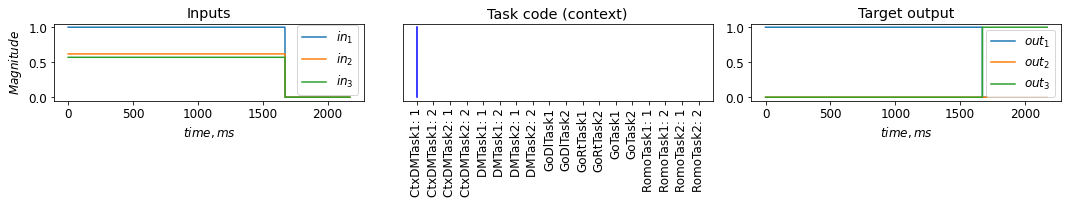

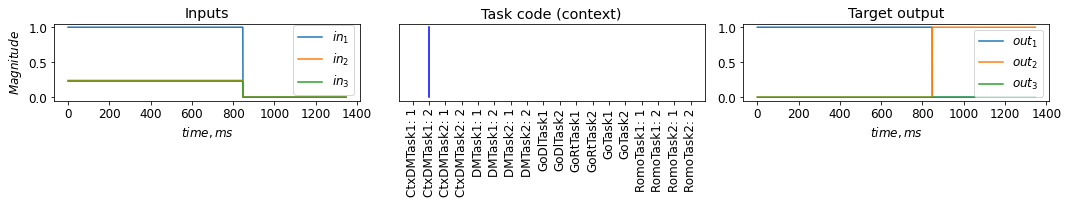

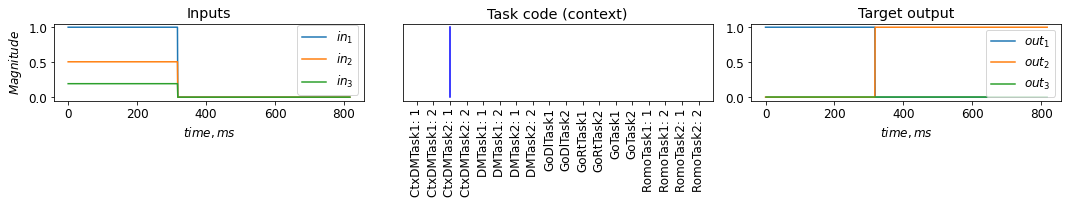

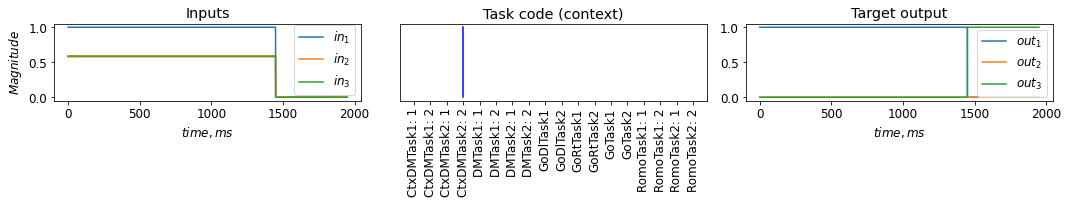

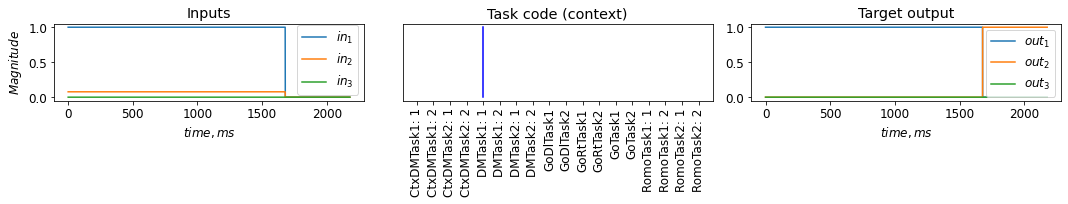

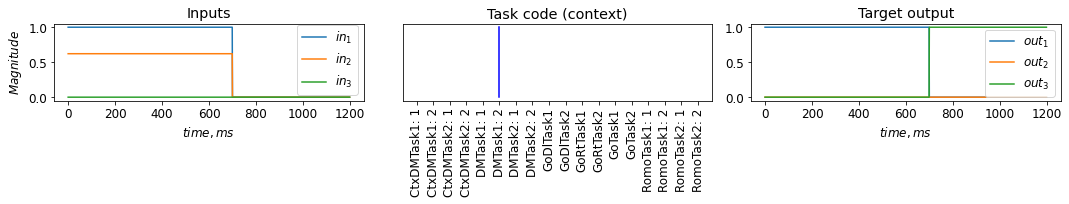

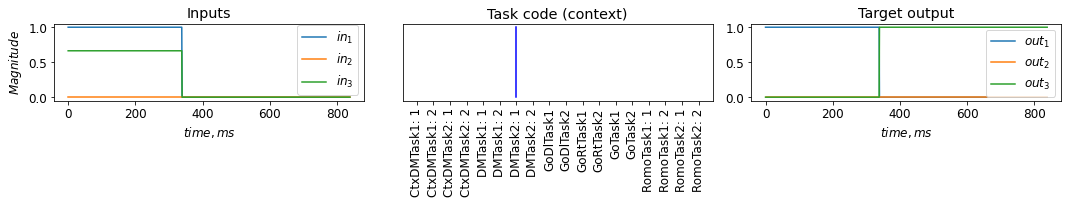

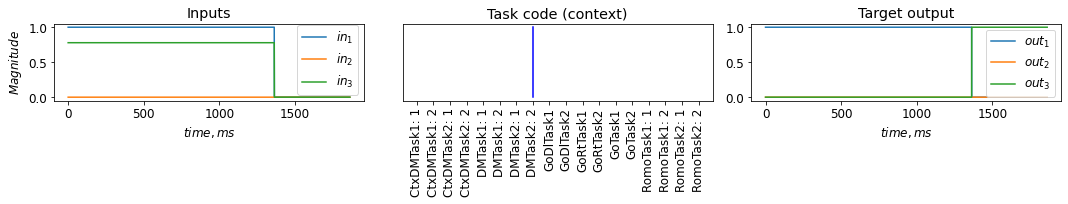

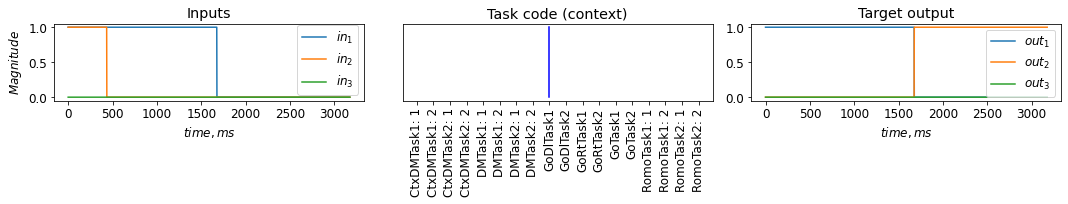

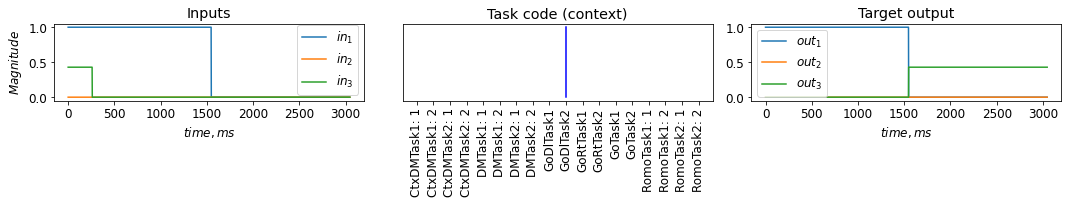

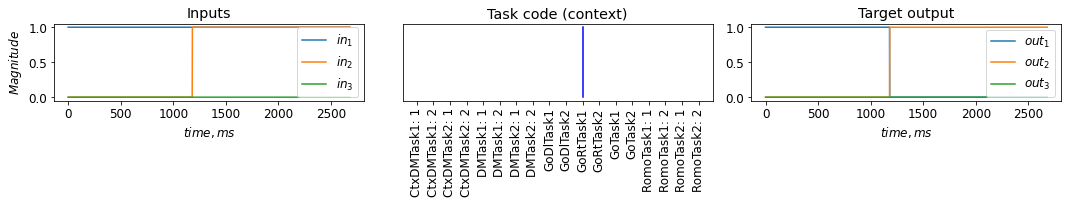

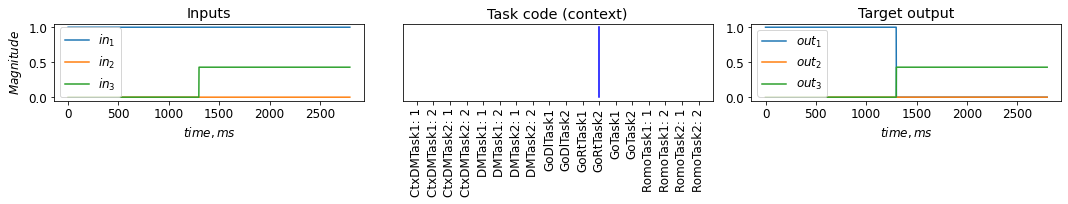

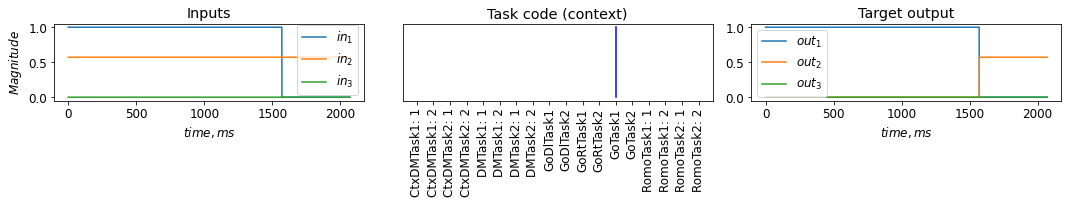

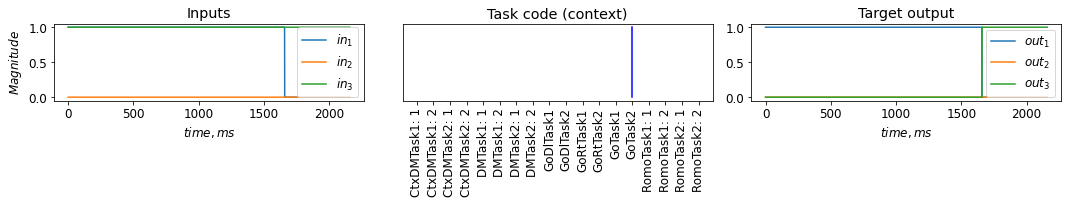

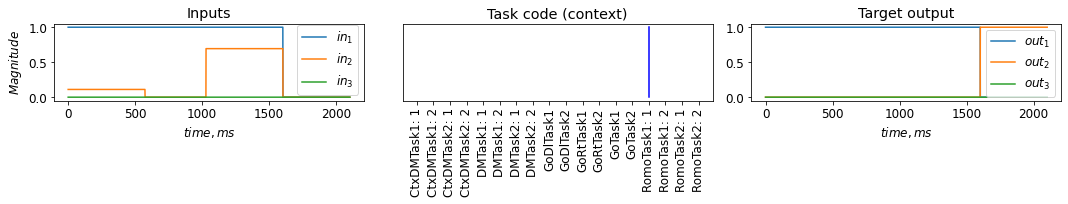

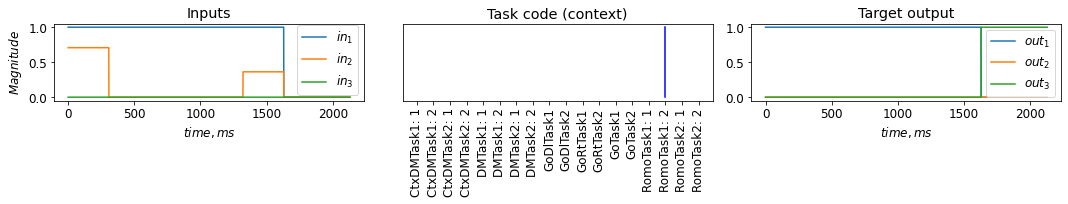

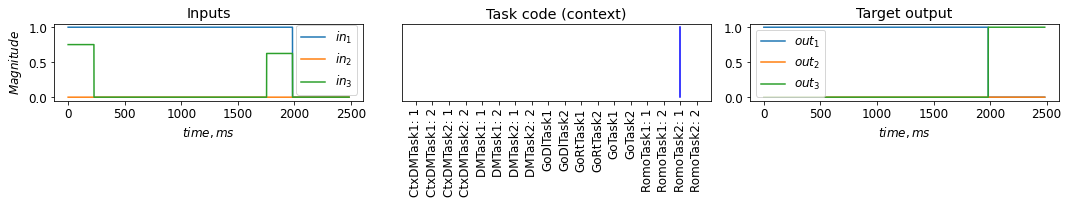

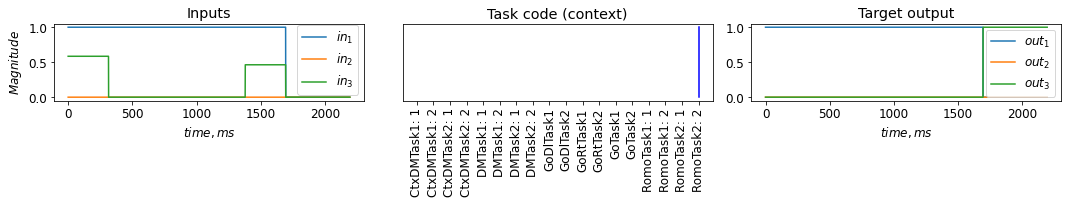

In [35]:
plt.rcParams["font.size"] = 12
for j in range(len(tasks_sequence)):
    task = tasks_sequence[j]

    inputs, t_outputs = task.dataset(n_trials=1)
    for batch in range(min(batch_size, 10)):
        fig = plt.figure(figsize=(15, 3))
    ax1 = fig.add_subplot(131)
    plt.title("Inputs")
    plt.xlabel("$time, ms$")
    plt.ylabel("$Magnitude$")
    for i in range(3):
        plt.plot(inputs[:, batch, i], label=rf"$in_{i + 1}$")
    plt.legend()
    plt.tight_layout()

    ax2 = fig.add_subplot(132)
    plt.title("Task code (context)")
    plt.xticks(range(0, len(tasks_couples)), sorted(tasks_couples), rotation=90)
    plt.yticks([])
    # for i in range(3, inputs.shape[-1]):
    # plt.plot([i - 2] * 2, [0, inputs[0, batch, i]], c='b')
    for i in range(len(tasks_sequence)):
        plt.plot([i], [0], c="b")
    plt.plot([j] * 2, [0, 1], c="b")
    plt.tight_layout()

    ax3 = fig.add_subplot(133)
    plt.title("Target output")
    plt.xlabel("$time, ms$")
    for i in range(t_outputs.shape[-1]):
        plt.plot(t_outputs[:, batch, i], label=rf"$out_{i + 1}$")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()
    del inputs
    del t_outputs

In [417]:
from cgtasknet.net import SNNlifadex
from norse.torch import LIFAdExParameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
feature_size, output_size = tasks_sequence[0].feature_and_act_size
hidden_size = 600
tau_a = "1/3"
neuron_parameters = LIFAdExParameters(
    v_th=torch.as_tensor(0.65),
    tau_ada_inv=float(eval(tau_a)),
    alpha=100,
    method="super",
)
model = SNNlifadex(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
    save_states=True,
    return_spiking=True,
).to(device)
model.load_state_dict(
    torch.load(
        rf"A:\src\long_intervals_list_go_task_improve_correct_functions_two_trials_600_neurons\Train_dm_and_romo_task_reduce_lif_adex_without_refrac_random_delay_long_a_alpha_100_N_600",
        # r"A:\src\multy_task\notebooks\train\reduce\lif_adex\romo_dm_ct_go_gort_godl\long_intervals_list_go_task_improve_correct_functions_two_trials\Train_dm_and_romo_task_reduce_lif_adex_without_refrac_random_delay_long_a_alpha_100_N_450",
        map_location=device,
    )
)
# tau_a = neuron_parameters.tau_ada_inv

<All keys matched successfully>

In [418]:
task_count = 1
batch = 0

fig = plt.figure(figsize=(12, 32))
for j in range(len(tasks_sequence)):
    task = tasks_sequence[j]

    inputs, t_outputs = task.dataset(n_trials=1)
    inputs = torch.from_numpy(inputs).type(torch.float)
    init_state = LIFAdExState(
        torch.zeros(batch_size, hidden_size).to(device),
        torch.rand(batch_size, hidden_size).to(device) * 1,
        torch.zeros(batch_size, hidden_size).to(device),
        torch.rand(batch_size, hidden_size).to(device) * 0.0,
    )
    output = model(inputs, init_state)[0]

    ax = fig.add_subplot(18, 4, task_count)
    if task_count == 1:
        plt.title("Inputs")
    if task_count == 45:
        plt.xlabel("$time, ms$")
    plt.ylabel("$Magnitude$")
    for i in range(3):
        plt.plot(inputs[:, batch, i], label="$u_{fix}$" if i == 0 else rf"u_{i}")
    plt.legend()

    ax = fig.add_subplot(18, 4, task_count + 1)
    if task_count == 1:
        plt.title("Task code (context)")
    # if task_count == 45:
    plt.xticks(
        range(0, len(tasks_couples), 1),
        sorted(tasks_couples)[::1],
        rotation=35,
        fontsize=8,
    )
    plt.yticks([])
    for i in range(len(tasks_sequence)):
        plt.plot([i], [0], c="b")
    plt.plot([j] * 2, [0, 1], c="b")

    ax = fig.add_subplot(18, 4, task_count + 2)
    if task_count == 1:
        plt.title("Target output")
    if task_count == 45:
        plt.xlabel("$time, ms$")
    for i in range(t_outputs.shape[-1]):
        plt.plot(
            t_outputs[:, batch, i],
            label=r"$\hat y_{fix}$" if i == 0 else rf"$\hat y_{i}$",
        )

    plt.legend()
    ax = fig.add_subplot(18, 4, task_count + 3)
    if task_count == 1:
        plt.title("Network output")
    ax.set_ylim([-0.1, 1.1])
    if task_count == 45:
        plt.xlabel("$time, ms$")
    for i in range(t_outputs.shape[-1]):
        plt.plot(
            output[:, batch, i].detach().cpu(),
            label="$y_{fix}$" if i == 0 else rf"y_{i}",
        )
    plt.legend()
    del inputs
    del t_outputs
    task_count += 4
plt.tight_layout()
# plt.savefig('task_demonstrate.pdf')
plt.show()
plt.close()


KeyboardInterrupt



In [419]:
type_tasks = []
tasks_couples.sort()
print(tasks_couples)
for i in range(len(tasks_couples)):
    if ": 1" in tasks_couples[i]:
        type_tasks.append(1)
    elif ": 2" in tasks_couples[i]:
        type_tasks.append(2)
    else:
        type_tasks.append(0)
subgroups = EveryTaskSubgroups(model, tasks_sequence, type_tasks)
subgroups.device = device
subgroups.run(100)
fixations, answers = subgroups.get_frequencies()

['CtxDMTask1: 1', 'CtxDMTask1: 2', 'CtxDMTask2: 1', 'CtxDMTask2: 2', 'DMTask1: 1', 'DMTask1: 2', 'DMTask2: 1', 'DMTask2: 2', 'GoDlTask1', 'GoDlTask2', 'GoRtTask1', 'GoRtTask2', 'GoTask1', 'GoTask2', 'RomoTask1: 1', 'RomoTask1: 2', 'RomoTask2: 1', 'RomoTask2: 2']
******************** Start
Complete task: 0, time: 59.00926469999831s
Complete task: 0, time: 79.74502110000321s
Complete task: 1, time: 50.1533816999945s
Complete task: 1, time: 144.97729470000195s
Complete task: 2, time: 61.90873439999996s
Complete task: 2, time: 92.67646380000224s
Complete task: 3, time: 72.32991559999937s
Complete task: 3, time: 194.14788419999968s
Complete task: 4, time: 132.94190629999503s
Complete task: 5, time: 148.38996790000238s
Complete task: 6, time: 178.45163370000228s
Complete task: 7, time: 151.07963610000297s
Complete task: 8, time: 77.44252090000373s
Complete task: 9, time: 79.32868459999736s
Complete task: 10, time: 108.13414200000261s
Complete task: 10, time: 112.42516990000149s
Complete task

# Silent neurons

In [532]:
silent_neurons = set()
threshold = 90

for i in range(len(tasks_sequence)):
    inter_section_silent_neurons = set(
        torch.where(fixations[i] <= threshold)[0].numpy()
    )
    inter_section_silent_neurons = inter_section_silent_neurons & set(
        torch.where(answers[i] <= threshold)[0].numpy()
    )
    if len(silent_neurons) == 0:
        silent_neurons = inter_section_silent_neurons
    else:
        silent_neurons = silent_neurons & inter_section_silent_neurons
silent_neurons = list(silent_neurons)
len(silent_neurons)

436

# Fixation neurons

In [533]:
fixation_neurons = set()
for i in range(len(tasks_sequence)):
    inter_section_fixation_neurons = set(
        torch.where(fixations[i] > threshold)[0].numpy()
    )
    if len(fixation_neurons) == 0:
        fixation_neurons = inter_section_fixation_neurons
    else:
        fixation_neurons = fixation_neurons | inter_section_fixation_neurons
fixation_neurons = list(fixation_neurons)
len(fixation_neurons)

53

# First category

In [534]:
first_category_tasks = [*range(0, 18, 2)]
print(first_category_tasks)
first_category = set()
for i in first_category_tasks:
    inter_section_first_category_neurons = set(
        torch.where(answers[i] > threshold)[0].numpy()
    )
    if len(first_category) == 0:
        first_category = inter_section_first_category_neurons
    else:
        first_category = first_category | inter_section_first_category_neurons
first_category = first_category - set(fixation_neurons)
first_category = list(first_category)
len(first_category)

[0, 2, 4, 6, 8, 10, 12, 14, 16]


62

# Second category

In [535]:
second_category_tasks = [*range(1, 18, 2)]
second_category = set()
for i in second_category_tasks:
    inter_section_second_category_neurons = set(
        torch.where(answers[i] > threshold)[0].numpy()
    )
    if len(second_category) == 0:
        second_category = inter_section_second_category_neurons
    else:
        second_category = second_category | inter_section_first_category_neurons
second_category = second_category - set(fixation_neurons)
second_category = list(second_category)
len(second_category)

59

In [536]:
class bcolors:
    HEADER = "\033[95m"
    OKBLUE = "\033[94m"
    OKCYAN = "\033[96m"
    OKGREEN = "\033[92m"
    WARNING = "\033[93m"
    FAIL = "\033[91m"
    ENDC = "\033[0m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"


mean_weights = dict()

weights = []
for name, item in model.named_parameters():
    weights.append(item.cpu().detach())


def from_smth_to_another(smth: str, another: str, weights: torch.tensor):
    added_spaces = " "
    mean_weights[f"{smth} ->{added_spaces}{another}"] = torch.mean(weights)


for i in range(3):
    from_smth_to_another(
        f"Win_{i + 1}", "silent neurons", weights[0][silent_neurons, i]
    )
for i in range(3):
    from_smth_to_another(
        f"Win_{i + 1}", "fixation neurons", weights[0][fixation_neurons, i]
    )
for i in range(3):
    from_smth_to_another(f"Win_{i + 1}", "A1", weights[0][first_category, i])
for i in range(3):
    from_smth_to_another(f"Win_{i + 1}", "A2", weights[0][second_category, i])

from_smth_to_another(f"Win tasks", "silent neurons", weights[0][silent_neurons, 3:])
from_smth_to_another("Win tasks", "fixation neurons", weights[0][fixation_neurons, 3:])
from_smth_to_another("Win tasks", "A1", weights[0][first_category, 3:])
from_smth_to_another("Win tasks", "A2", weights[0][second_category, 3:])

for i in range(3):
    from_smth_to_another(
        f"silent neurons", f"Wout_{i + 1}", weights[2][i, silent_neurons]
    )
from_smth_to_another(
    "silent neurons", "A1", weights[1][first_category, :][:, silent_neurons]
)
from_smth_to_another(
    "silent neurons", "A2", weights[1][second_category, :][:, silent_neurons]
)
from_smth_to_another(
    "silent neurons",
    "fixation neurons",
    weights[1][fixation_neurons, :][:, silent_neurons],
)
from_smth_to_another(
    "silent neurons", "silent neurons", weights[1][silent_neurons, :][:, silent_neurons]
)

for i in range(3):
    from_smth_to_another(
        f"fixation neurons", f"Wout_{i + 1}", weights[2][i, fixation_neurons]
    )
from_smth_to_another(
    "fixation neurons",
    "silent neurons",
    weights[1][silent_neurons, :][:, fixation_neurons],
)
from_smth_to_another(
    "fixation neurons", "A1", weights[1][first_category, :][:, fixation_neurons]
)
from_smth_to_another(
    "fixation neurons", "A2", weights[1][second_category, :][:, fixation_neurons]
)
from_smth_to_another(
    "fixation neurons",
    "fixation neurons",
    weights[1][fixation_neurons, :][:, fixation_neurons],
)

for i in range(3):
    from_smth_to_another(f"A1", f"Wout_{i + 1}", weights[2][i, first_category])
from_smth_to_another(
    "A1", "fixation neurons", weights[1][fixation_neurons, :][:, first_category]
)
from_smth_to_another(
    "A1", "silent neurons", weights[1][silent_neurons, :][:, first_category]
)
from_smth_to_another("A1", "A2", weights[1][second_category, :][:, first_category])
from_smth_to_another("A1", "A1", weights[1][first_category, :][:, first_category])

for i in range(3):
    from_smth_to_another(f"A2", f"Wout_{i + 1}", weights[2][i, second_category])
from_smth_to_another(
    "A2", "fixation neurons", weights[1][fixation_neurons, :][:, second_category]
)
from_smth_to_another(
    "A2", "silent neurons", weights[1][silent_neurons, :][:, second_category]
)

from_smth_to_another("A2", "A1", weights[1][first_category, :][:, second_category])
from_smth_to_another("A2", "A2", weights[1][second_category, :][:, second_category])

for key, item in mean_weights.items():
    print(
        f'{key:}: {bcolors.OKGREEN}{"-" if item < 0 else "+"} {round(item.abs().item(), 3)}{bcolors.ENDC}'
    )

Win_1 -> silent neurons: - 0.03
Win_2 -> silent neurons: - 0.02
Win_3 -> silent neurons: - 0.004
Win_1 -> fixation neurons: + 0.422
Win_2 -> fixation neurons: - 0.062
Win_3 -> fixation neurons: - 0.049
Win_1 -> A1: - 0.203
Win_2 -> A1: + 0.117
Win_3 -> A1: - 0.022
Win_1 -> A2: - 0.237
Win_2 -> A2: + 0.008
Win_3 -> A2: - 0.018
Win tasks -> silent neurons: - 0.138
Win tasks -> fixation neurons: - 0.016
Win tasks -> A1: - 0.181
Win tasks -> A2: - 0.219
silent neurons -> Wout_1: + 0.006
silent neurons -> Wout_2: - 0.002
silent neurons -> Wout_3: - 0.001
silent neurons -> A1: - 0.062
silent neurons -> A2: - 0.062
silent neurons -> fixation neurons: - 0.005
silent neurons -> silent neurons: - 0.039
fixation neurons -> Wout_1: + 0.013
fixation neurons -> Wout_2: - 0.002
fixation neurons -> Wout_3: - 0.004
fixation neurons -> silent neurons: - 0.058
fixation neurons -> A1: - 0.099
fixation neurons -> A2: - 0.113
fixation neurons -> fixation neurons: + 0.011
A1 -> Wout_1: - 0.001
A1 -> Wout_2: 

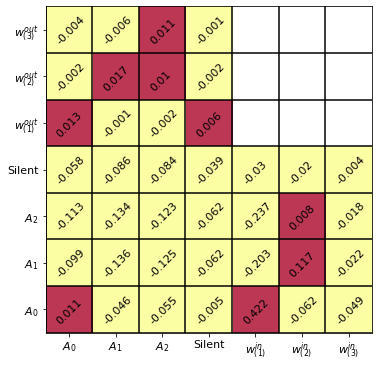

In [601]:
%matplotlib inline
plt.rcParams["font.size"] = 11
map_weights = np.zeros((7, 7))
map_weights[0, 0] = mean_weights["fixation neurons -> fixation neurons"]
map_weights[1, 0] = mean_weights["fixation neurons -> A1"]
map_weights[2, 0] = mean_weights["fixation neurons -> A2"]
map_weights[3, 0] = mean_weights["fixation neurons -> silent neurons"]

map_weights[0, 1] = mean_weights["A1 -> fixation neurons"]
map_weights[1, 1] = mean_weights["A1 -> A1"]
map_weights[2, 1] = mean_weights["A1 -> A2"]
map_weights[3, 1] = mean_weights["A1 -> silent neurons"]

map_weights[0, 2] = mean_weights["A2 -> fixation neurons"]
map_weights[1, 2] = mean_weights["A2 -> A1"]
map_weights[2, 2] = mean_weights["A2 -> A2"]
map_weights[3, 2] = mean_weights["A2 -> silent neurons"]

map_weights[0, 3] = mean_weights["silent neurons -> fixation neurons"]
map_weights[1, 3] = mean_weights["silent neurons -> A1"]
map_weights[2, 3] = mean_weights["silent neurons -> A2"]
map_weights[3, 3] = mean_weights["silent neurons -> silent neurons"]

names = ["fixation neurons", "A1", "A2", "silent neurons"]

map_weights[4:, 4:] = None

for i in range(3):
    for j in range(len(names)):
        name = names[j]
        map_weights[j, i + 4] = mean_weights[f"Win_{i + 1} -> {name}"]
        map_weights[i + 4, j] = mean_weights[f"{name} -> Wout_{i + 1}"]
plt.figure(figsize=(7, 6))
# plt.grid(
map_weights_numbers = np.copy(map_weights)
indexes = np.where((1 - np.isnan(map_weights)) == 1)
map_weights[indexes[0], indexes[1]] = map_weights[indexes[0], indexes[1]] < 0
plt.imshow(map_weights, cmap="inferno", origin="lower", vmin=-0.6, vmax=0.6)
for i in range(len(map_weights)):
    plt.plot([i - 0.5] * 2, [-0.5, len(map_weights) - 0.5], c="black")
    plt.plot([-0.5, len(map_weights) - 0.5], [i - 0.5] * 2, c="black")
    for j in range(len(map_weights)):
        # plt.text(i, j, '+' if map_weights[j, i] > 0 else ('-' if not np.isnan(map_weights[j, i]) else ''), fontsize=30,
        # ha='center', va='center')
        plt.text(
            i - 0.3,
            j - 0.3,
            str(round(map_weights_numbers[j, i], 3))
            if not np.isnan(map_weights[i, j])
            else "",
            rotation=45,
            c="black",
        )
# plt.xlim([-.5, 3.5])

labels_x = [
    "$A_0$",
    "$A_1$",
    "$A_2$",
    "Silent",
    "$w^{in}_{(1)}$",
    "$w^{in}_{(2)}$",
    "$w^{in}_{(3)}$",
]
labels_y = [
    "$A_0$",
    "$A_1$",
    "$A_2$",
    "Silent",
    "$w^{out}_{(1)}$",
    "$w^{out}_{(2)}$",
    "$w^{out}_{(3)}$",
]
plt.xticks([*range(len(labels_x))], labels_x)
plt.yticks([*range(len(labels_y))], labels_y)
# cbar = plt.colorbar()
# cbar.set_label('Average value of weights')
# plt.ylim([-.5, 3.5])
plt.show()

In [578]:
1 - np.isnan(map_weights)

array([[1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0]])

In [565]:
np.where((1 - np.isnan(map_weights)) == 1)

(array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6], dtype=int64),
 array([0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0,
        1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3], dtype=int64))

In [537]:
map_weights[-1, -1] == np.nan

False

In [539]:
import os

folder = f"data_tau_{tau_a.replace('/', '_')}_v_th_0_65_{hidden_size}"
if not os.path.exists(folder):
    os.mkdir(folder)
load_status = 'save'
if load_status == 'save':
    for
i in range(len(fixations)):
torch.save(fixations[i], f'{folder}/fixation_{i}')
torch.save(answers[i], f'{folder}/answer_{i}')
elif load_status == 'load':
fixations, answers = [], []
for i in range(len(tasks)):
    fixations.append(torch.load(f'{folder}/fixation_{i}'))
answers.append(torch.load(f'{folder}/answer_{i}'))

SyntaxError: invalid syntax (753586787.py, line 8)

In [60]:
fixations[4].max()

tensor(992.6935)

In [11]:
for name, params in model.named_parameters():
    print(f"{name=} {params.shape=}")

name='alif.input_weights' params.shape=torch.Size([600, 15])
name='alif.recurrent_weights' params.shape=torch.Size([600, 600])
name='exp_f.linear.weight' params.shape=torch.Size([3, 600])
name='exp_f.linear.bias' params.shape=torch.Size([3])


In [12]:
zeros_frequencies = set()
zeros_frequencies_answers = set()
zeros_frequencies_fixations = set()
threshold = 20
for i in range(len(fixations)):

inter_section = set(torch.where(fixations[i] <= threshold)[0].numpy())
inter_section = inter_section & set(torch.where(answers[i] <= threshold)[0].numpy())
if len(zeros_frequencies) == 0:
    zeros_frequencies = inter_section
else:
    zeros_frequencies = zeros_frequencies & inter_section

if len(zeros_frequencies_fixations) == 0:
    zeros_frequencies_fixations = set(torch.where(fixations[i] <= threshold)[0].numpy())
else:
    zeros_frequencies_fixations = zeros_frequencies_fixations & set(
        torch.where(fixations[i] <= threshold)[0].numpy())

if len(zeros_frequencies_answers) == 0:
    zeros_frequencies_answers = set(torch.where(answers[i] <= threshold)[0].numpy())
else:
    zeros_frequencies_answers = zeros_frequencies_answers & set(torch.where(answers[i] <= threshold)[0].numpy())
len(zeros_frequencies)

220

In [13]:
print(zeros_frequencies_answers)
print(zeros_frequencies_fixations)

{513, 2, 515, 4, 518, 7, 520, 9, 521, 11, 523, 525, 526, 15, 16, 529, 530, 19, 21, 22, 533, 534, 535, 26, 536, 538, 29, 30, 540, 32, 33, 545, 35, 36, 37, 38, 39, 40, 548, 550, 43, 552, 45, 553, 47, 48, 555, 556, 51, 52, 558, 559, 55, 56, 560, 562, 59, 563, 61, 566, 567, 64, 65, 569, 67, 68, 69, 575, 71, 576, 581, 582, 75, 583, 77, 584, 79, 80, 81, 586, 589, 84, 85, 590, 87, 88, 593, 90, 91, 92, 598, 599, 97, 99, 102, 104, 105, 107, 108, 111, 112, 115, 116, 117, 118, 119, 122, 123, 126, 127, 131, 132, 133, 137, 139, 141, 142, 143, 145, 146, 148, 149, 153, 155, 157, 163, 167, 169, 172, 180, 184, 185, 186, 188, 189, 191, 192, 193, 194, 195, 196, 198, 201, 203, 205, 209, 214, 215, 218, 222, 223, 224, 227, 228, 229, 233, 235, 236, 240, 241, 244, 247, 248, 250, 251, 253, 254, 255, 256, 259, 260, 261, 266, 268, 269, 274, 278, 564, 282, 283, 284, 285, 286, 287, 290, 291, 292, 293, 298, 300, 304, 306, 570, 310, 311, 312, 313, 316, 318, 572, 320, 324, 326, 328, 330, 331, 333, 334, 339, 340, 341,

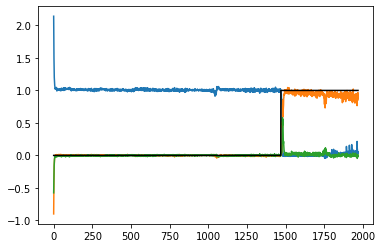

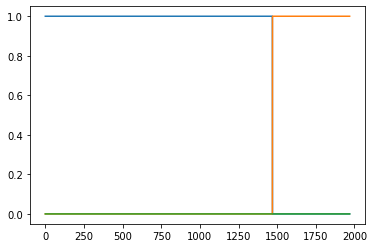

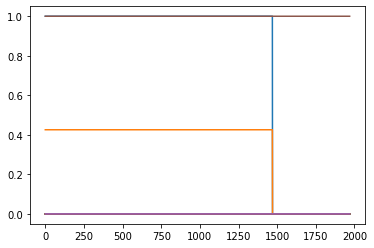

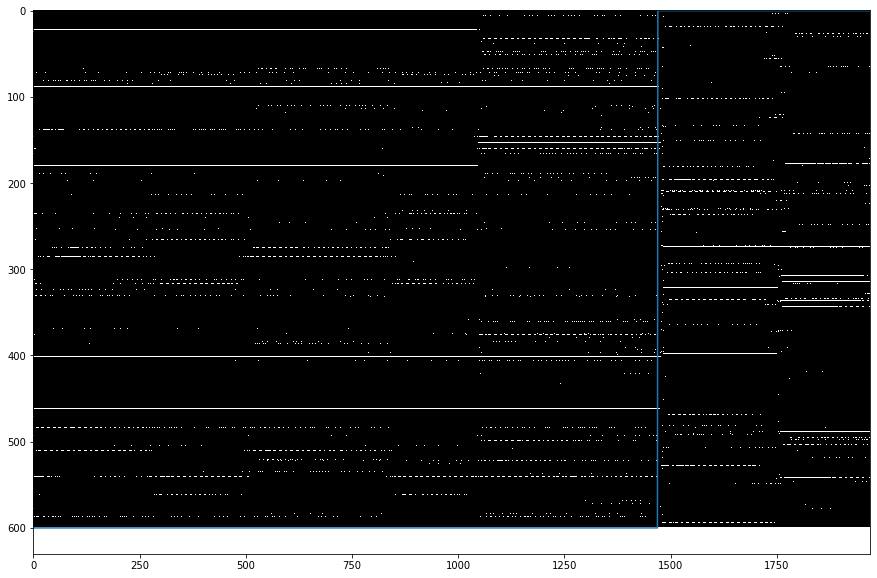

In [369]:
% matplotlib inline
from norse.torch import LIFAdExState
from matplotlib import colors

inputs, t_outputs = tasks_sequence[4].dataset(1)
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
# inputs = torch.zeros((3000, 1, feature_size)).to(device)
init_state = LIFAdExState(
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device) * 1,
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device) * 0.0,
)
outputs, states, s = model(inputs, init_state)
plt.plot(outputs[:, 0, 0].detach().cpu())
plt.plot(outputs[:, 0, 1].detach().cpu())

plt.plot(outputs[:, 0, 2].detach().cpu())
plt.plot(t_outputs[:, 0, 1], c="black")
plt.figure()
plt.plot(t_outputs[:, 0, :])
plt.figure()
plt.plot(inputs[:, 0, :].cpu())

plt.show()
plt.close()
if isinstance(s, list):
    s = torch.concat(s)
s = s.detach().cpu()
cmap = colors.ListedColormap(["black", "white"])
bounds = [0, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.figure(figsize=(15, 10))
plt.imshow(s[:, :].T, aspect="auto", interpolation="nearest", cmap=cmap, norm=norm)
plt.plot(inputs[:, 0, 0].cpu() * hidden_size)
plt.show()
plt.close()

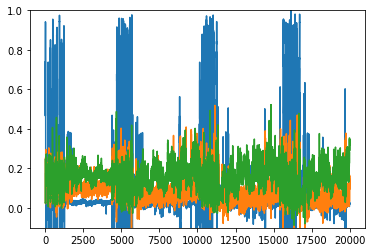

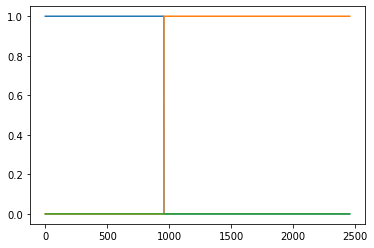

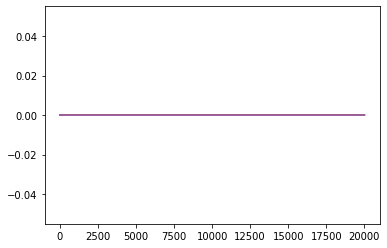

In [16]:
inputs = torch.zeros((20000, 1, feature_size)).to(device)
init_state = LIFAdExState(
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device) * 1.0,
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device) * 0.0,
)
outputs, states, s = model(inputs, init_state)

plt.plot(outputs[:, 0, 0].detach().cpu())
plt.plot(outputs[:, 0, 1].detach().cpu())
plt.plot(outputs[:, 0, 2].detach().cpu())
plt.ylim([-0.1, 1])
plt.figure()
plt.plot(t_outputs[:, 0, :])
plt.figure()
plt.plot(inputs[:, 0, :].cpu())

In [17]:
v = []
a = []
for i in range(len(states)):
    v.append(states[i].v)
a.append(states[i].a)

In [18]:
if isinstance(v, list):
    v = torch.concat(v).detach().cpu()
if isinstance(a, list):
    a = torch.concat(a).detach().cpu()

In [19]:
for name, params in model.named_parameters():
    if name == "alif.recurrent_weights":
        w_rec = params.detach().cpu()

In [20]:
torch.sum(w_rec[fixations[0].argmin().item(), :])

tensor(-33.8022)

In [21]:
fixations[0].max()

tensor(999.9999)

In [22]:
isinstance(s, list)

True

In [23]:
from norse.torch import LIFAdExState

inputs = torch.zeros((20000, 1, feature_size)).to(device)
number_of_loop = 1
sum_s = None
count = 0
for i in tqdm(range(number_of_loop)):
    init_state = LIFAdExState(
        torch.zeros(batch_size, hidden_size).to(device),
        torch.rand(batch_size, hidden_size).to(device) * 1,
        torch.zeros(batch_size, hidden_size).to(device),
        torch.rand(batch_size, hidden_size).to(device) * 0,
    )
outputs = model(inputs, init_state)
s = torch.concat(outputs[-1][10000:], dim=0).cpu().detach()
if sum_s is None:
    sum_s = torch.sum(s, dim=0)
else:
    sum_s += torch.sum(s, dim=0)
count += len(s)
mean_zero_input = sum_s / count / number_of_loop / 1e-3

100%|██████████| 1/1 [00:06<00:00,  6.41s/it]


In [355]:
import numpy as np


def plot_hist(data, c="#003153", alpha=1):
    x = np.arange(0, len(data), 1)
    for i in range(len(data)):
        plt.plot([x[i]] * 2, [0, data[i]], c=c, alpha=alpha, linewidth=0.5)

In [27]:
for name, params in model.named_parameters():
    if name == "exp_f.linear.weight":
        out_weights = torch.clone(params.detach()).cpu()

In [460]:
for name, params in model.named_parameters():
    print(name)
    if name == "alif.input_weights":
        input_weights = torch.clone(params.detach()).cpu()
    if name == "exp_f.linear.weight":
        out_weights = torch.clone(params.detach()).cpu()

alif.input_weights
alif.recurrent_weights
exp_f.linear.weight
exp_f.linear.bias


In [461]:
from cgtasknet.instruments.instrument_subgroups import sort_elemnts_by_another

fixation_by_fixation_out = [
    fixations[i] * out_weights[0, :] for i in range(len(fixations))
]
fixation_by_first_out = [
    fixations[i] * out_weights[1, :] for i in range(len(fixations))
]
answer_by_first_out = [answers[i] * out_weights[1, :] for i in range(len(answers))]

fixation_sort_by_first = [sort_elemnts_by_another(fixations[0], el) for el in fixations]
answer_sort_by_fixation = [sort_elemnts_by_another(fixations[0], el) for el in answers]

answer_sort_by_first = [sort_elemnts_by_another(answers[0], el) for el in answers]

fixation_sort_by_first_strength = [
    sort_elemnts_by_another(answer_by_first_out[0], el) for el in fixations
]
answer_sort_by_first_strength = [
    sort_elemnts_by_another(answer_by_first_out[0], el) for el in answers
]

fixation_strength_by_answer_strength_sort = [
    sort_elemnts_by_another(answer_by_first_out[0], el) for el in fixation_by_first_out
]

answer_strength_by_answer_strength_sort = [
    sort_elemnts_by_another(answer_by_first_out[0], el) for el in answer_by_first_out
]

In [ ]:
% matplotlib inline

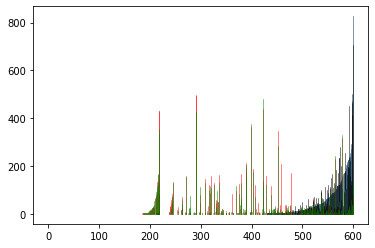

In [479]:
plot_hist(answer_sort_by_first[0])
plot_hist(answer_sort_by_first[1], c="r")
plot_hist(answer_sort_by_first[2], c="black")
plot_hist(answer_sort_by_first[3], c="g")
# plt.xlim([500, 600])

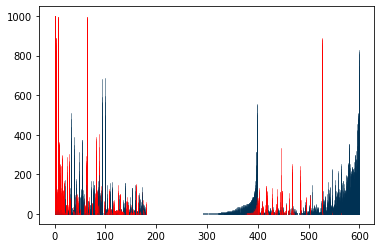

In [466]:
for i in range(len(fixations)):
    plot_hist(answer_sort_by_first_strength[i])
    plot_hist(fixation_sort_by_first_strength[i], c="r")

plt.show()
plt.close()

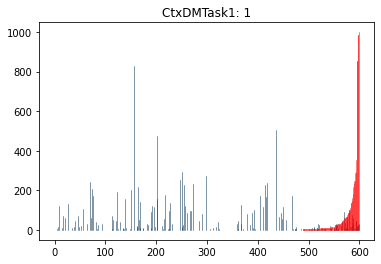

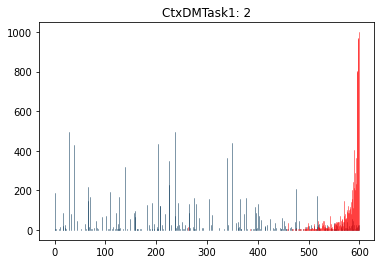

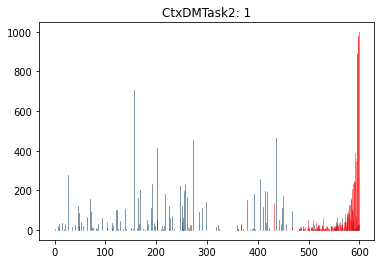

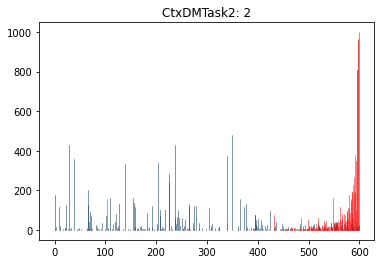

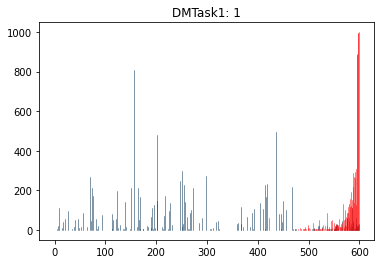

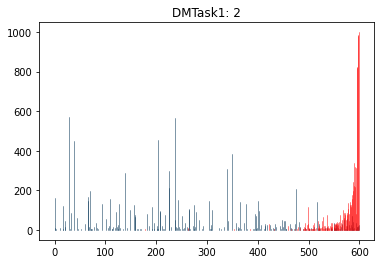

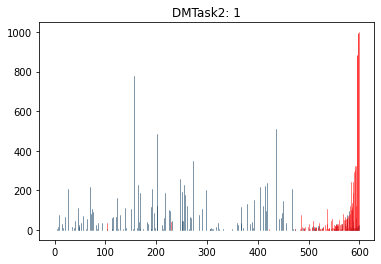

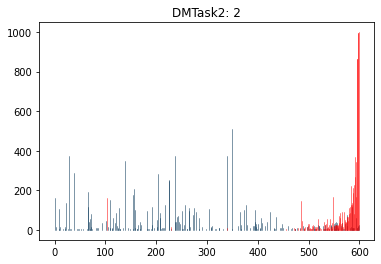

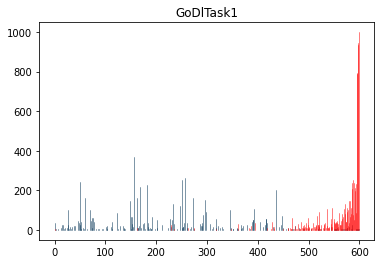

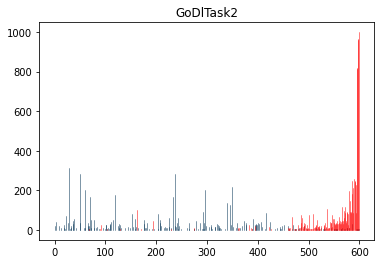

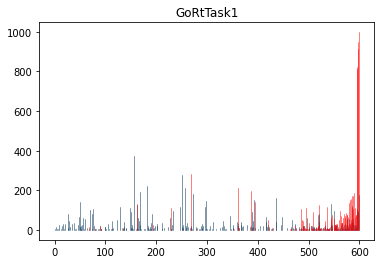

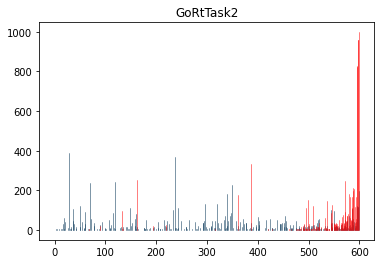

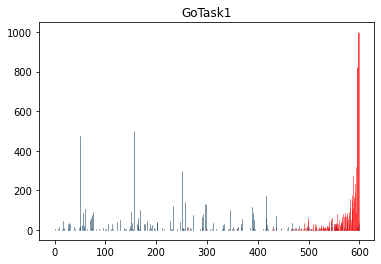

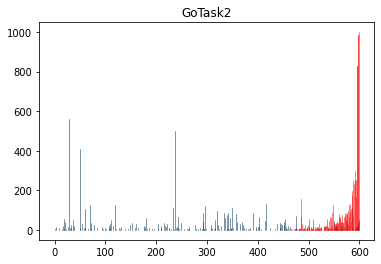

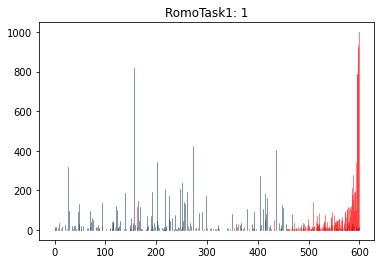

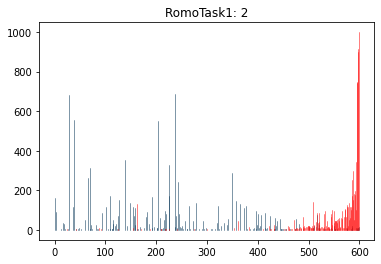

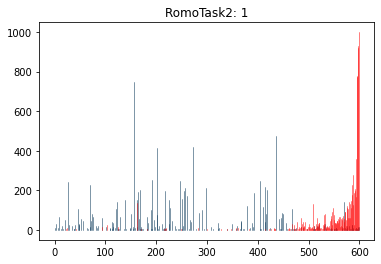

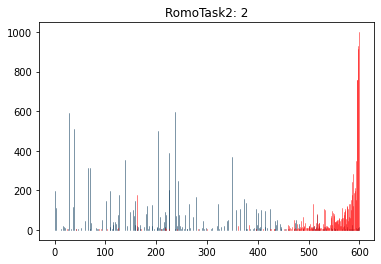

In [465]:
% matplotlib inline
sorted_tasks = sorted(tasks_couples)
for i in range(len(fixations)):
    plot_hist(answer_sort_by_fixation[i])
    plot_hist(fixation_sort_by_first[i], c="r")
    plt.title(sorted_tasks[i])

    plt.show()
    plt.close()

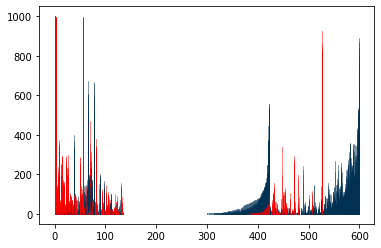

In [358]:
for i in range(len(fixations)):
    plot_hist(answer_sort_by_first_strength[i])
    plot_hist(fixation_sort_by_first_strength[i], c="r")

plt.show()
plt.close()

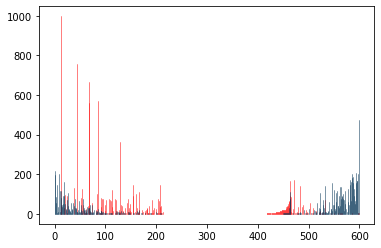

In [38]:
index = 1

plot_hist(fixation_sort_by_first_strength[index], c="r")
plot_hist(answer_sort_by_first_strength[index])

In [158]:
zeros_inputs_sort_by_fixation = sort_elemnts_by_another(
    answer_by_first_out[0], mean_zero_input
)

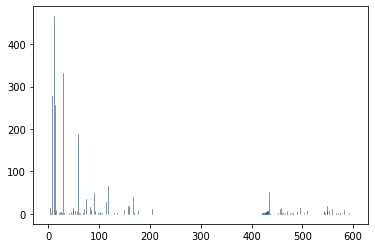

In [159]:
plot_hist(zeros_inputs_sort_by_fixation)

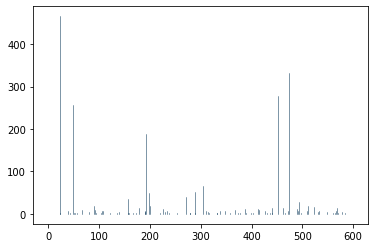

In [160]:
plot_hist(mean_zero_input)

# Сортировка частот во время интервала фиксации по первому графику (т.е. по задаче CtxDMTask1)

IndexError: list index out of range

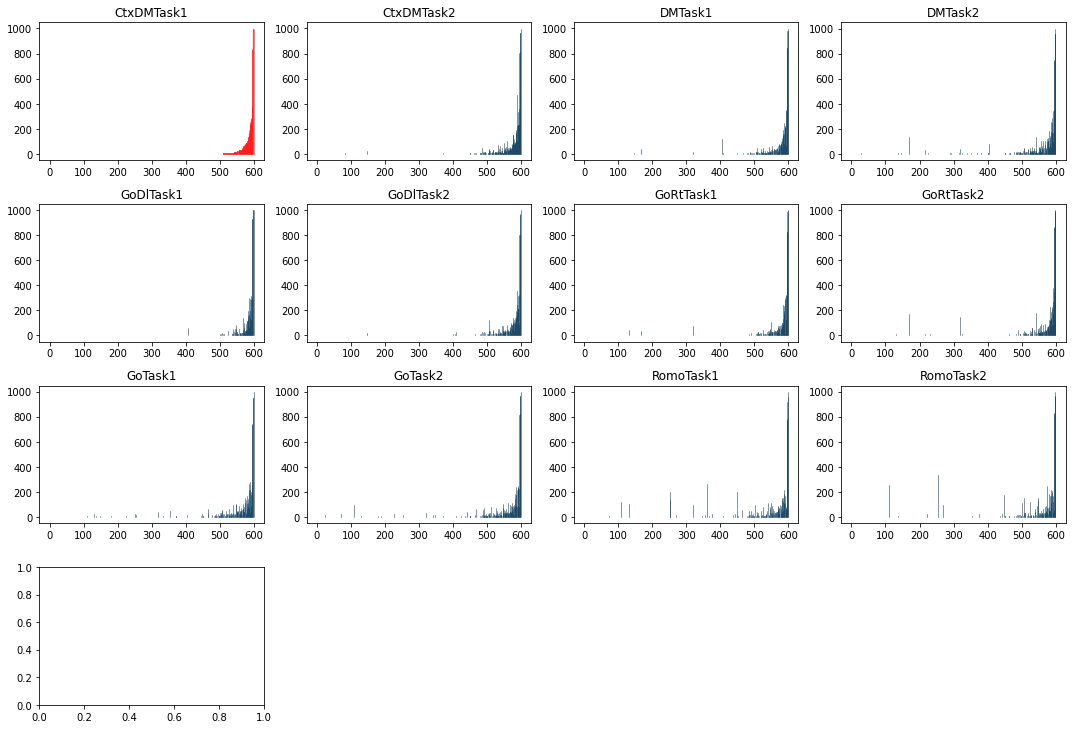

In [360]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(fixation_sort_by_first)):
    plt.subplot(4, 4, i + 1)
    plt.title(sorted(tasks)[i])
    if i == 0:
        plot_hist(fixation_sort_by_first[i], c="r")
    else:
        plot_hist(fixation_sort_by_first[i])
    plt.tight_layout()
plt.show()
plt.close()

# Сортировка частот во время отклика по первому графику (т.е. по CtxDMTask1)

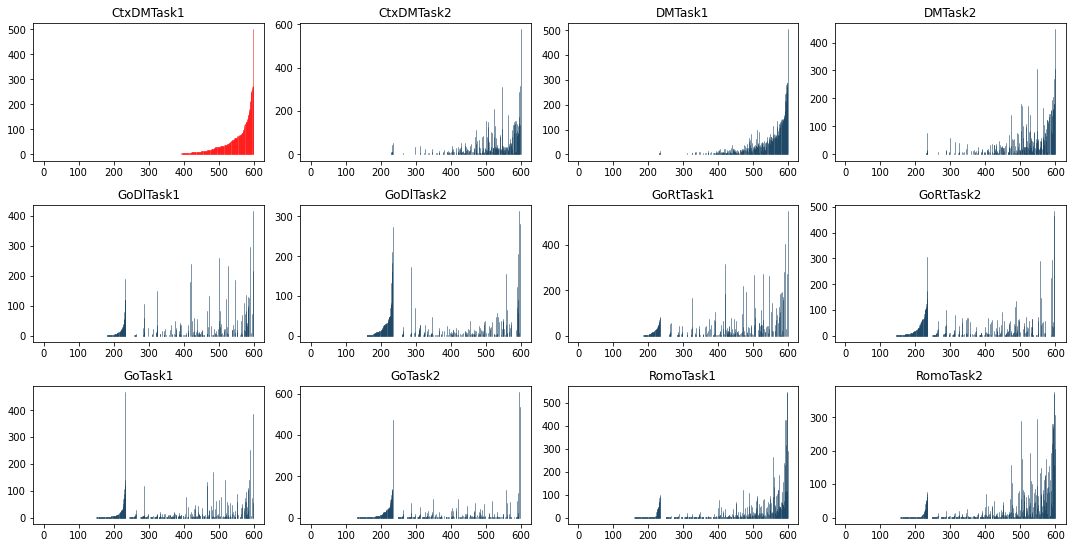

In [33]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(answer_sort_by_first)):
    plt.subplot(4, 4, i + 1)
    plt.title(sorted(tasks)[i])
    plot_hist(answer_sort_by_first[i], c="red" if i == 0 else "#003153")
    plt.tight_layout()
plt.show()
plt.close()

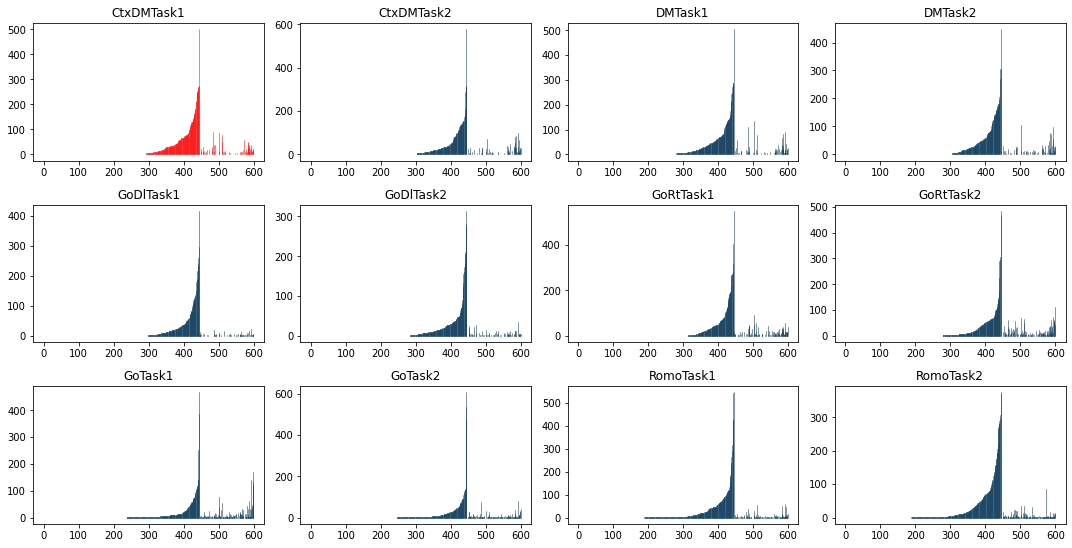

In [34]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(answer_sort_by_fixation)):
    plt.subplot(4, 4, i + 1)
    plt.title(sorted(tasks)[i])
    plot_hist(answer_sort_by_fixation[i], c="red" if i == 0 else "#003153")
    plt.tight_layout()
plt.show()
plt.close()

# Сортировка частот во время фиксации по вкладу в первый выход (активный выход)

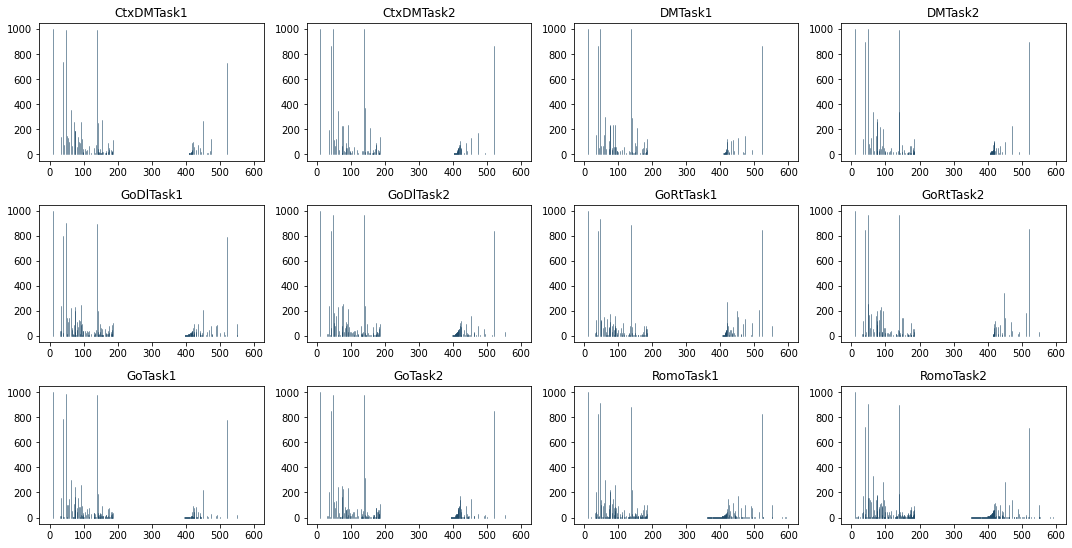

In [35]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(fixation_sort_by_first_strength)):
    plt.subplot(4, 4, i + 1)
    plt.title(sorted(tasks)[i])
    plot_hist(fixation_sort_by_first_strength[i])
    plt.tight_layout()
plt.show()
plt.close()

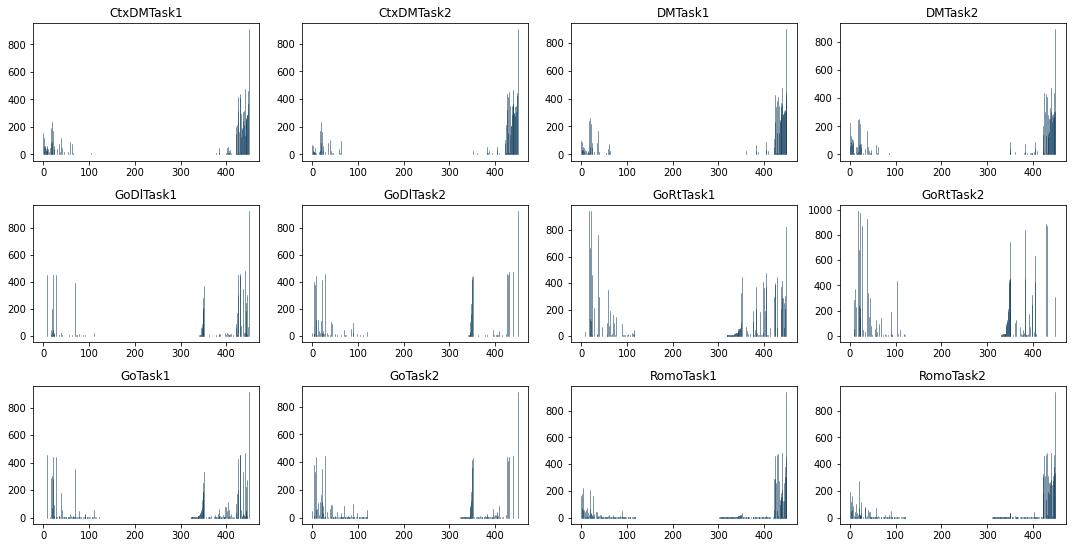

In [16]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(answer_sort_by_first_strength)):
    plt.subplot(4, 4, i + 1)
    plt.title(sorted(tasks)[i])
    plot_hist(answer_sort_by_first_strength[i])
    plt.tight_layout()
plt.show()
plt.close()

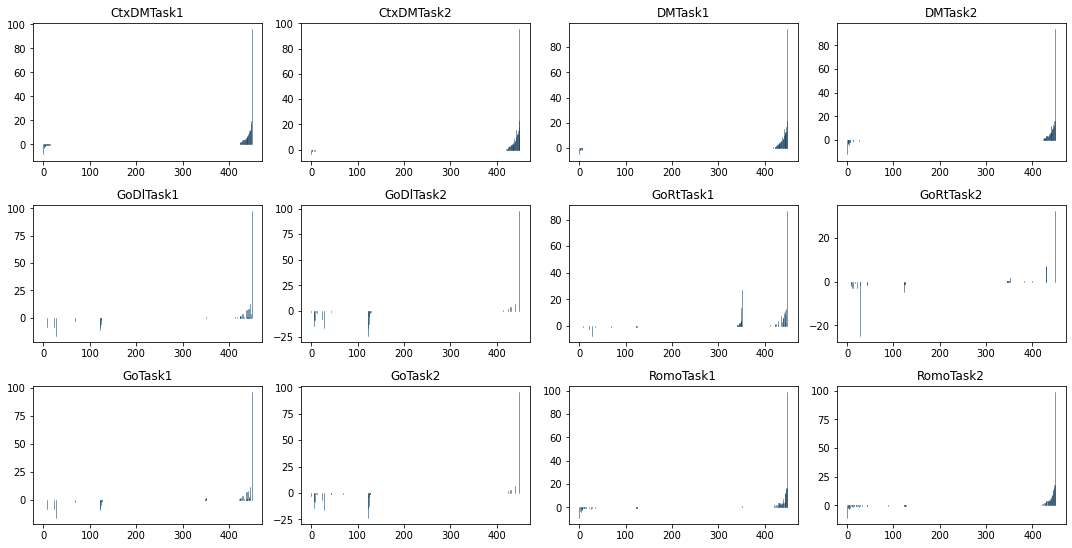

In [17]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(answer_strength_by_answer_strength_sort)):
    plt.subplot(4, 4, i + 1)
    plt.title(sorted(tasks)[i])
    plot_hist(answer_strength_by_answer_strength_sort[i])
    plt.tight_layout()
plt.show()
plt.close()

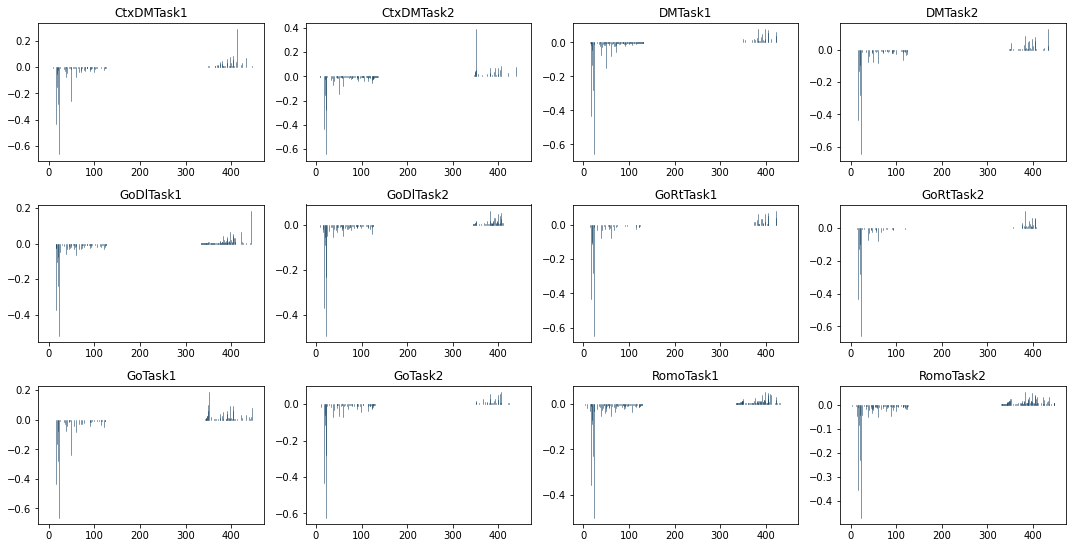

In [18]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(fixation_strength_by_answer_strength_sort)):
    plt.subplot(4, 4, i + 1)
    plt.title(sorted(tasks)[i])
    plot_hist(fixation_strength_by_answer_strength_sort[i])
    plt.tight_layout()
plt.show()
plt.close()

In [38]:
indexes_for_sort = [*range(hidden_size)]
indexes_for_sort = sort_elemnts_by_another(answer_by_first_out[0], indexes_for_sort)

In [51]:
for name, params in model.named_parameters():
    if name == "alif.input_weights":
        input_weights = torch.clone(params.detach()).cpu()
input_weights = [input_weights[:, i] for i in range(input_weights.shape[1])]
sort_input_weights = [torch.zeros_like(el) for el in input_weights]
for i in range(len(sort_input_weights)):
    for j in range(hidden_size):
        sort_input_weights[i][j] = input_weights[i][indexes_for_sort[j]]

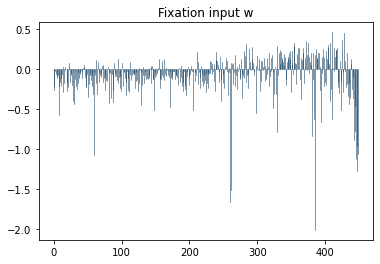

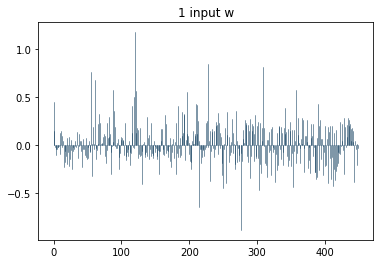

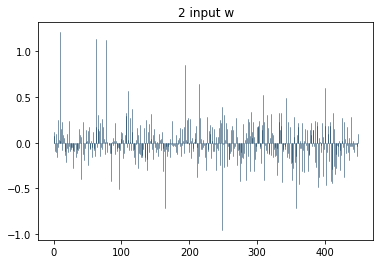

In [52]:
plt.title("Fixation input w")
plot_hist(sort_input_weights[0])
plt.show()
plt.close()
plt.title("1 input w")
plot_hist(sort_input_weights[1])
plt.show()
plt.close()
plt.title("2 input w")
plot_hist(sort_input_weights[2])
plt.show()
plt.close()

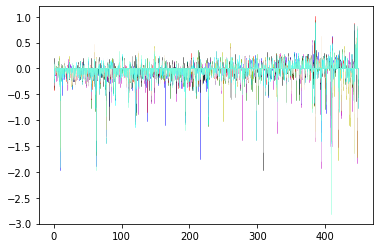

In [67]:
cmap = plt.cm.Spectral
import matplotlib.colors as mcolors

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = [key for key in colors]
for i in range(3, len(sort_input_weights)):
    plot_hist(sort_input_weights[i], c=colors[i - 3])
plt.show()
plt.close()

In [64]:
import matplotlib.colors as mcolors

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = [key for key in colors]

In [65]:
colors

['b',
 'g',
 'r',
 'c',
 'm',
 'y',
 'k',
 'w',
 'aliceblue',
 'antiquewhite',
 'aqua',
 'aquamarine',
 'azure',
 'beige',
 'bisque',
 'black',
 'blanchedalmond',
 'blue',
 'blueviolet',
 'brown',
 'burlywood',
 'cadetblue',
 'chartreuse',
 'chocolate',
 'coral',
 'cornflowerblue',
 'cornsilk',
 'crimson',
 'cyan',
 'darkblue',
 'darkcyan',
 'darkgoldenrod',
 'darkgray',
 'darkgreen',
 'darkgrey',
 'darkkhaki',
 'darkmagenta',
 'darkolivegreen',
 'darkorange',
 'darkorchid',
 'darkred',
 'darksalmon',
 'darkseagreen',
 'darkslateblue',
 'darkslategray',
 'darkslategrey',
 'darkturquoise',
 'darkviolet',
 'deeppink',
 'deepskyblue',
 'dimgray',
 'dimgrey',
 'dodgerblue',
 'firebrick',
 'floralwhite',
 'forestgreen',
 'fuchsia',
 'gainsboro',
 'ghostwhite',
 'gold',
 'goldenrod',
 'gray',
 'green',
 'greenyellow',
 'grey',
 'honeydew',
 'hotpink',
 'indianred',
 'indigo',
 'ivory',
 'khaki',
 'lavender',
 'lavenderblush',
 'lawngreen',
 'lemonchiffon',
 'lightblue',
 'lightcoral',
 'ligh

In [71]:
answers_np

NameError: name 'answers_np' is not defined